# Homework 5

## Due date

## Question 1

Consider the workbook *TermStructure.xlsm*. The worksheet *Discount Curve* contains market quotes as of February 19 2018 for 16 liquid instruments (cells D4:D19), namely the 3 Month Libor rate, 6 eurodollar futures for medium term maturities and adjusted for convexity, and 9 swap rates for longer maturities up to 10-year (see the Bloomberg screen below). The cash flow associated with each instrument is already reported in the cells H4:AJ19, which have been conveniently named **CashFlows**.

- Write a piece of software that uses Moore-Penrose inverse to calibrate a smooth zero curve. For the smoothing spline, check this library: https://docs.scipy.org/doc/scipy/tutorial/interpolate/smoothing_splines.html. The keyword argument $s$ specifies the amount of smoothing to perform during the spline fit. You should start by setting this parameter to $0$. The maturities for each instrument are in the cell range named **Dates**. Finally, the current prices of each instrument is in the cell range named **Prices**. Report the calculated discount rates in the range named **SmoothedDiscountCurve**. 
- Plot raw yield rates from market quotes. What do you notice?
- Now choose the parameter $s$ so that the yield curve is increasing and $s$ is as small as possible
- Plot the smoothed yield curve on the same figure with the raw yield rates.
- As a matter of fact, the longer maturities in the smoothed yield curve (above 20 year) as of February 18 2018 were below the 10-year rate. What is the economic meaning of this?

In [10]:
from openpyxl import load_workbook
from openpyxl.styles import Alignment
import numpy as np
from scipy.interpolate import splrep, BSpline
import matplotlib.pyplot as plt
import os

QRM_path = os.path.dirname(os.getcwd()) 
file_path = QRM_path+'//Homework//TermStructure.xlsm'

wb = load_workbook(filename=file_path, data_only=True)

In [11]:
# Get all matrices
Matrices = dict()
for dn in list(wb.defined_names):
    data_range = wb.defined_names[dn]
    matrix = []
    for sheetname, cellAddress in data_range.destinations:
        ws = wb[sheetname] 
        cellAddress = cellAddress.replace('$','')
        try:
            nrows = len(ws[cellAddress][0][0:-1])+1
            ncols = len(ws[cellAddress])
            for i in range(nrows):
                matrix.append([])
                for j in range(ncols):
                    matrix[i].append(ws[cellAddress][j][i].value)
            Matrices[dn] = np.array(matrix).transpose()
        except:
            Matrices[dn] = np.array([ws[cellAddress].value])



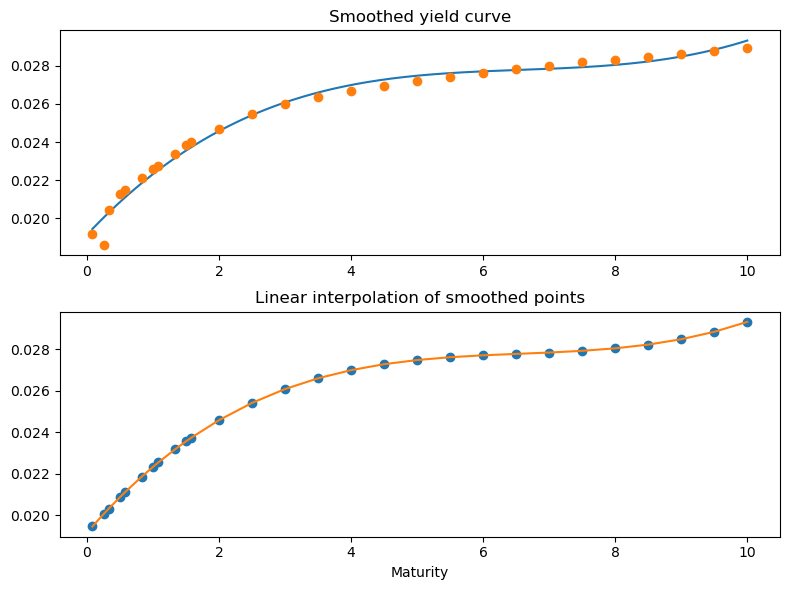

In [ ]:
## Discount Curve via Moore Penrose Pseudoinverse matrix method
# D. Filipovic, W. Sanders, Exact Smooth Term Structure (2016)

# Discount Rates via Pseudoinverse matrix method
C = Matrices["CashFlows"]
p = Matrices["Prices"]
T = Matrices["Dates"].T

[n,N] = np.shape(C); 
I = np.eye(N)
M = I-np.eye(N=N,k=-1)
Minv = np.linalg.inv(M)
T0 = np.hstack((0,T[0][:-1]))
dT = 1/np.sqrt( T[0] - T0 )
W = np.diag(dT.ravel())
Winv = np.linalg.inv(W)
A = C  @ ( Minv ) @ ( Winv )
D = A.T @ ( np.linalg.inv(A @ A.T) ) @ ( p - C @ ( Minv ) @ np.eye(N=N,M=1) )
d = ( Minv ) @ ( Winv @ D + np.eye(N=N,M=1) )

# Interpolation via smoothing splines
T = T.T
yy = -np.log(d) / T; # compute yields
y = splrep(T, yy, s = 0.00001)

# Smoothed discount Curve points
ynew = BSpline(*y)(T); # discount curve
dnew = np.exp(-ynew*T); # discount curve

# Create plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
Tnew = np.linspace(0.08,10,1000)
ax1.plot(Tnew, BSpline(*y)(Tnew))
ax1.plot(T, yy, 'o')
ax1.set_title('Smoothed yield curve')
ax2.plot(T, BSpline(*y)(T), 'o')
ax2.plot(T, ynew)
ax2.set_xlabel('Maturity')
ax2.set_title('Linear interpolation of smoothed points')
# Show the plot
plt.tight_layout()
plt.subplots_adjust(hspace=0.25)
plt.show()



Report the discount rates in the Excel workbook

In [13]:
wb.close()
wb = load_workbook(filename=file_path, read_only=False, keep_vba=True)
excel_col_name = lambda n: '' if n <= 0 else excel_col_name((n - 1) // 26) + chr((n - 1) % 26 + ord('A'))

Range = wb.defined_names["SmoothedDiscountCurve"]

for sheetname, cellAddress in wb.defined_names["SmoothedDiscountCurve"].destinations:
    ws = wb[sheetname]
    cellAddress = cellAddress.replace('$','')
    i = 0
    for cell in ws[cellAddress]:
        x = cell[0]
        x.value = dnew[i][0]
        i += 1

wb.save(file_path)
wb.close()

Check your results

In [14]:
os.system('start "excel" ' + '"' + file_path + '"')

0

An inverted yield curve typically represents investors' expectation that the Federal Reserve will increase rates soon. This was indeed the expectation throughout 2018.

## Question 2

Now look at the worksheet *Volatility Smile*. The quotes (in terms of Black volatility) for caps is reported in cells D3:D12. Column F3:F12 shows the corresponding market price of the cap, while column G3:G12 reports the price of the cap based on the Hull-White model for Mean reversion and volatility as in cell L3 and L4 respectively.

- Find the best volatility parameter such that the mean square error (cell L6) is minimized. You should do this using python's scipy.optimize library (see the documentation here: https://docs.scipy.org/doc/scipy/tutorial/optimize.html).
- Plot the market implied vol and the Hull-White vol. Which part of the volatility curve is best fit by the Hull White model?

As a matter of fact, your findings are quite usual. See section 3.14 and, in particular, Figure 3.16 on page 134 of **Interest Rate Models - Theory and Practice**, by Damiano Brigo and Fabio Mercurio.